In [74]:
##Libraries Needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.linear_model import LogisticRegression
import xgboost as xgb_lib
from xgboost import XGBClassifier

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

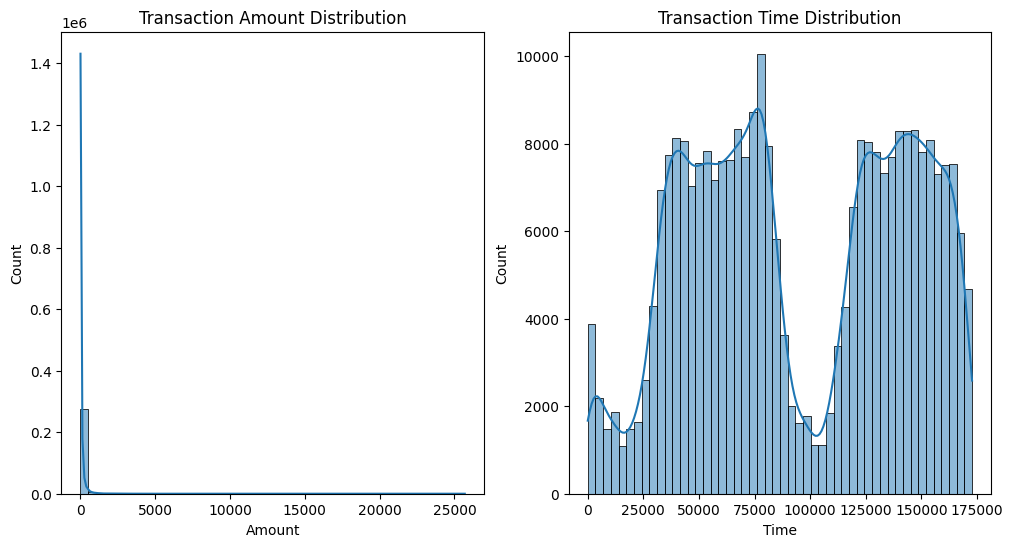

In [75]:
## Please download the dataset and add to the same directory this file is in
df = pd.read_csv("creditcard.csv")

## Key stats
print("Dataset Info:")
print(df.info())
print("\nClass Distribution:")
print(df['Class'].value_counts(normalize=True))

## Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

# Feature distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['Amount'], bins=50, ax=ax[0], kde=True)
ax[0].set_title("Transaction Amount Distribution")
sns.histplot(df['Time'], bins=50, ax=ax[1], kde=True)
ax[1].set_title("Transaction Time Distribution")
plt.show()

In [76]:
## Function to display the ROC-AUC curve - Called down below

def show_ROC(y_test, next_param):
    fpr, tpr, _ = roc_curve(y_test, next_param)
    auc_score = roc_auc_score(y_test, next_param)

    ## Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56863
           1       0.97      0.89      0.93     17059

    accuracy                           0.97     73922
   macro avg       0.97      0.94      0.95     73922
weighted avg       0.97      0.97      0.97     73922

ROC-AUC Score: 0.9392490546208778


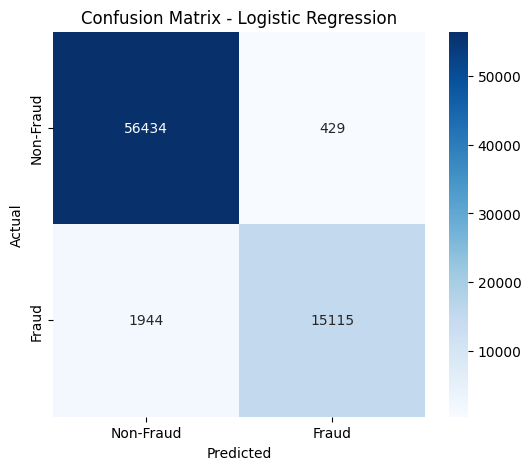

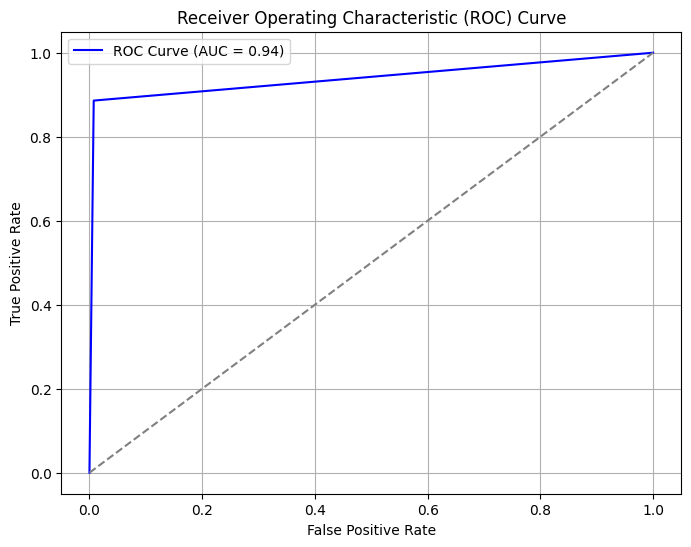

c:\Users\vsohe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     17059

    accuracy                           1.00     73922
   macro avg       1.00      1.00      1.00     73922
weighted avg       1.00      1.00      1.00     73922

ROC-AUC Score: 0.9997508633576024


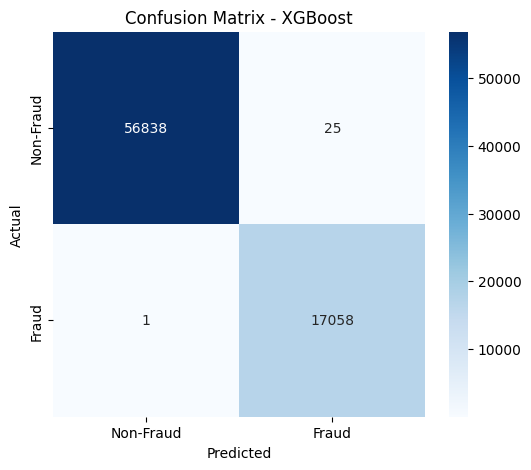

<Figure size 1000x800 with 0 Axes>

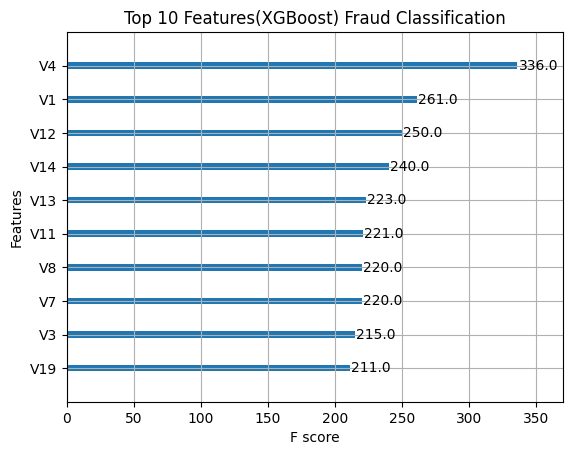

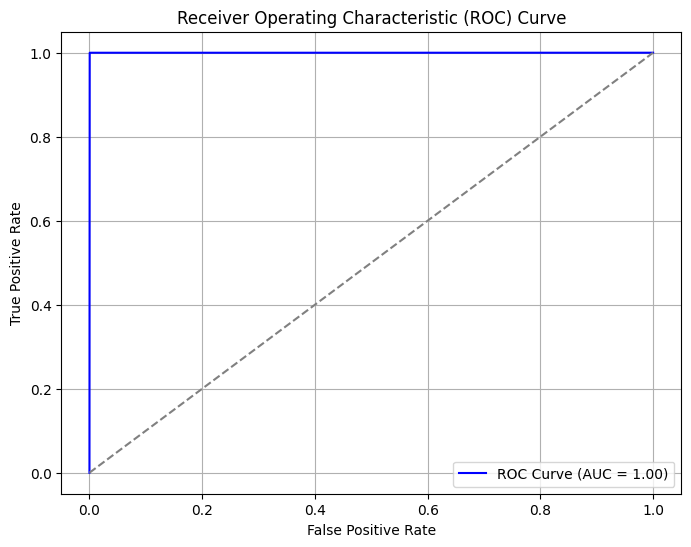

In [77]:
## Function for preprossing the data for Baseline Model and XGB
## Choice is given to apply SMOTE or not when function is called

def start_base_and_XGB(df, apply_smote=False):
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
    df['Time'] = scaler.fit_transform(df[['Time']])
    
    X = df.drop(columns=['Class'])
    y = df['Class']
    
    if apply_smote:
        smote = SMOTE(sampling_strategy=0.3, random_state=42)
        X, y = smote.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    build_md1(X_train, y_train, X_test, y_test) 
    
## Function for model building after preprocessing the data for Baseline Model and XGB

def build_md1(X_train, y_train, X_test, y_test):

    ## Logistic Reg Code Block
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print("\nLogistic Regression Performance:")
    print(classification_report(y_test, y_pred_lr))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_lr))

    cm_lr = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix - Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    show_ROC(y_test, y_pred_lr)

    ## XGB Code Block
    xgb = XGBClassifier(n_estimators=50, max_depth = 10, use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("\nXGBoost Performance:")
    print(classification_report(y_test, y_pred_xgb))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))

    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix - XGBoost')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    ## Feature Importance for XGB
    plt.figure(figsize=(10, 8))
    xgb_lib.plot_importance(xgb, importance_type='weight', max_num_features=10, title='Top 10 Features(XGBoost) Fraud Classification')
    plt.show()

    show_ROC(y_test, y_pred_xgb)


## Function called
start_base_and_XGB(df, apply_smote=True) ## <---- Here is the choice for applying SMOTE

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0492 - val_loss: 0.8689
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8761 - val_loss: 0.8451
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8412 - val_loss: 0.8319
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8355 - val_loss: 0.8253
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8237 - val_loss: 0.8191
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8416 - val_loss: 0.8153
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8233 - val_loss: 0.8125
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8216 - val_loss: 0.8106
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8205 - val_loss: 0.8091
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8253 - val_loss: 0.8083
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8136 - val_loss: 0.8075
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

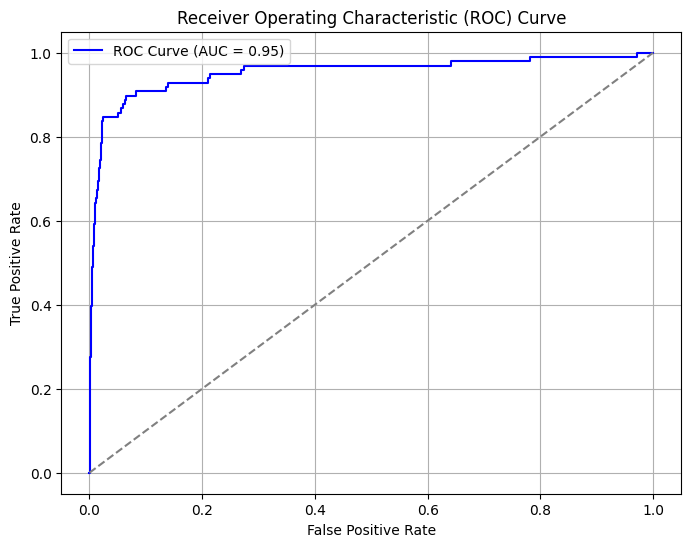

In [ ]:
## Function for preprossing the data for Autoencoder
## Choice is given to apply SMOTE or not when function is called

def start_auto(df,apply_smote=False):
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
    df['Time'] = scaler.fit_transform(df[['Time']])

    X = df.drop(columns=['Class'])
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if apply_smote:
        smote = SMOTE(sampling_strategy=0.3, random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    X_train_normal = X_train[y_train == 0]
    build_md2(X_test, y_test, X_train_normal)

## Function for model building after preprocessing the data for Autoencoder

def build_md2(X_test, y_test, X_train_normal):
    input_dim = X_train_normal.shape[1]
    encoding_dim = 16

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    X_test_reconstructed = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

    threshold = np.percentile(mse, 95)
    y_pred = (mse > threshold).astype(int)

    print("\nAutoencoder Model Performance:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, mse))

    show_ROC(y_test, mse)

start_auto(df, apply_smote=True) ## <---- Here is the choice for applying SMOTE